In [1]:
import numpy as np
import random
import gc
import time
import pandas as pd
from plotnine import *
from numpy.random import weibull

In [2]:
def runsim(num_reqs, failure_prob_thresh, num_trials=1):
    max_retries = 3
    successful_requests = np.full((num_reqs, num_trials), False)
    current_retries = np.full((num_reqs, num_trials), 0, dtype=np.uint8)
    all_retries = np.full((num_reqs, num_trials), 0, dtype=np.uint8)
    
    # run till all requests succeed or max retries at all levels are exhausted
    while (not np.all(successful_requests)) and np.all(current_retries < max_retries+1):
        random_nums = np.random.random_sample(size=(num_reqs, num_trials))
        successful_this_round = random_nums >= np.repeat(np.transpose([failure_prob_thresh]), num_trials, axis=1)
#         print(successful_this_round)
        
        valid_requests_this_round = ~successful_requests & (current_retries < max_retries+1)
        
        
        success_intermediate = (valid_requests_this_round & successful_this_round) | successful_requests
        (failure_rows, failure_columns) = np.nonzero(~success_intermediate)
        
        # So, if requests fail at level 2 and 3. Only the failure at 2 is counted
        # We can do this because failure_columns is SORTED in column order
        # take care: unique rows does not contain all rows. There are many rows without any failures
        (unique_rows, unique_indices) = np.unique(failure_rows, return_index=True)
        unique_rows_first_column = failure_columns[unique_indices]
        
        # Update retries
        current_retries[unique_rows, unique_rows_first_column] += 1
        all_retries[unique_rows, unique_rows_first_column] += 1
        
        repeated_unique_rows_first_column = np.repeat(np.transpose([unique_rows_first_column]), num_trials, axis=1)
        (row_indices, column_indices) = np.indices((num_reqs, num_trials))
        mask = np.full((num_reqs, num_trials), np.iinfo(np.int32).max, dtype=np.int32)
        mask[unique_rows] = repeated_unique_rows_first_column
#         print(mask)
        
        successful_requests = column_indices < mask

        # Rollback to previous level if max retries for this level has been reached
        rollback_mask = current_retries == max_retries
        (exhausted_retries_rows, exhausted_retries_columns) = np.nonzero(rollback_mask)
        exhausted_retries_prev_columns = exhausted_retries_columns - 1
#         print(exhausted_retries_prev_columns)
        valid_prev_col = exhausted_retries_prev_columns >= 0
#         print(valid_prev_col)
        can_be_retried_again_rows = exhausted_retries_rows[valid_prev_col]
        can_be_retried_again_columns = exhausted_retries_columns[valid_prev_col]
        
        exhausted_retries_prev_columns[~valid_prev_col] = 0
        successful_requests[exhausted_retries_rows, exhausted_retries_prev_columns] = False
        current_retries[can_be_retried_again_rows, can_be_retried_again_columns] = 0
    
    # https://lup.lub.lu.se/search/ws/files/5764781/4814056.pdf
    # Magnitude of sin from above paper
    sin_input = np.linspace(-np.pi, np.pi, 24*60*60)
    sin_scaler = np.tile((np.sin(sin_input) + 1) / 2, 365) # Sin min magnitude 0, max 1, for 365 days
    
    results = {}
    overall_successful_requests = np.all(successful_requests, axis=1)
    retries_per_request = np.sum(all_retries, axis=1)
    consolidated_retries = retries_per_request[overall_successful_requests]
    filtered_sin_scaler = sin_scaler[overall_successful_requests]
#     print(consolidated_retries.shape)
#     print(filtered_sin_scaler.shape)
#     return (True, True)
    unique_retries = np.unique(consolidated_retries)
    for entry in unique_retries:
        results[entry] = np.round(np.sum(filtered_sin_scaler[consolidated_retries == entry]))
#     print(np.transpose(successful_requests))
    scaled_unsuccessful_requests = ~overall_successful_requests * sin_scaler
    return (results, np.sum(scaled_unsuccessful_requests))

sin_input = np.linspace(-np.pi, np.pi, 24*60*60)
per_day_sin_scaler = (np.sin(sin_input) + 1) / 2
num_reqs = 365*24*60*60
scaled_num_reqs = np.sum(per_day_sin_scaler) * 365
print(num_reqs)
print(np.round(scaled_num_reqs))
# 20min is outage report granularity
num_20min_chunks = num_reqs // (20*60)
failure_probabilities = np.repeat(0.01, num_20min_chunks)
failure_prob_thresh = np.repeat(failure_probabilities, 20*60)

(results, failed_reqs) = runsim(num_reqs, np.transpose(failure_prob_thresh), num_trials=5)
# (results, failed_reqs) = runsim(10, np.repeat(0.5, 10), num_trials=5)
print(results, failed_reqs)

31536000
15768000.0
{0: 14995272.0, 1: 749658.0, 2: 22542.0, 3: 508.0, 4: 9.0} 10.926686001093943


In [5]:
def runsim_fanout(num_reqs, failure_prob_thresh, fanout=1):
    max_retries = 3
    successful_requests = np.full((num_reqs, fanout), False)
    current_retries = np.full((num_reqs, fanout), 0, dtype=np.uint8)
    
    # run till all requests succeed or max retries at all levels are exhausted
    while (not np.all(successful_requests)) and np.all(current_retries < max_retries+1):
        random_nums = np.random.random_sample(size=(num_reqs, fanout))
        successful_this_round = random_nums >= np.repeat(np.transpose([failure_prob_thresh]), fanout, axis=1)
        
        valid_requests_this_round = ~successful_requests & (current_retries < max_retries+1)
        successful_valid = valid_requests_this_round & successful_this_round
        
        # Update retries
        current_retries[~successful_valid] += 1
        
        successful_requests = successful_requests | successful_valid
        break
    
    results = {}
    overall_successful_requests = np.all(successful_requests, axis=1)
    consolidated_retries = np.sum(current_retries, axis=1)[overall_successful_requests]
    unique_retries = np.unique(consolidated_retries)
    for entry in unique_retries:
        results[entry] = np.sum(consolidated_retries == entry)
    return (results, np.sum(~overall_successful_requests))


num_reqs = 365*24*60*60
# 20min is outage report granularity
num_20min_chunks = num_reqs // (20*60)
failure_probabilities = np.repeat(0.01, num_20min_chunks)
failure_prob_thresh = np.repeat(failure_probabilities, 20*60)

(results, failed_reqs) = runsim_fanout(num_reqs, np.transpose(failure_prob_thresh), fanout=10)
# (results, failed_reqs) = runsim_fanout(10, np.repeat(0.01, 10), fanout=10)
print(results, failed_reqs)

{0: 28523119} 3012881


In [6]:
num_reqs = 365*24*60*60
# 20min is outage report granularity
num_20min_chunks = num_reqs // (20*60)
num_iterations = 1
results = []

In [7]:
for iteration in range(num_iterations):
    num_20min_chunks = num_reqs // (20*60)
    failure_probabilities = np.repeat(0.01, num_20min_chunks)
    failure_prob_thresh = np.repeat(failure_probabilities, 20*60)
    
#     (final_counts, failed_reqs) = runsim(num_reqs, failure_prob_thresh)
#     results.append(pd.DataFrame({
#         'vendor': 'uniform',
#         'reqs': list(final_counts.values()) + [failed_reqs],
#         'retries': list(final_counts.keys()) + [100],
#         'iteration': iteration,
#         'experiment': 'monolith'
#     }))
    
    (final_counts, failed_reqs) = runsim(num_reqs, failure_prob_thresh, num_trials=5)
    results.append(pd.DataFrame({
        'vendor': 'uniform',
        'reqs': list(final_counts.values()) + [failed_reqs],
        'retries': list(final_counts.keys()) + [100],
        'iteration': iteration,
        'experiment': 'deep chain'
    }))
    
#     (final_counts, failed_reqs) = runsim_fanout(num_reqs, failure_prob_thresh, fanout=10)
#     results.append(pd.DataFrame({
#         'vendor': 'uniform',
#         'reqs': list(final_counts.values()) + [failed_reqs],
#         'retries': list(final_counts.keys()) + [100],
#         'iteration': iteration,
#         'experiment': 'fanout'
#     }))

In [19]:
results

[    vendor      reqs  retries  iteration experiment
 0  uniform  28382785        0          0   monolith
 1  uniform   2837362        1          0   monolith
 2  uniform    284158        2          0   monolith
 3  uniform     28516        3          0   monolith
 4  uniform      3179      100          0   monolith,
     vendor      reqs  retries  iteration experiment
 0  uniform  28387324        0          0   monolith
 1  uniform   2834446        1          0   monolith
 2  uniform    282792        2          0   monolith
 3  uniform     28385        3          0   monolith
 4  uniform      3053      100          0   monolith,
     vendor      reqs  retries  iteration  experiment
 0  uniform  18618827        0          0  deep chain
 1  uniform   9311619        1          0  deep chain
 2  uniform   2795059        2          0  deep chain
 3  uniform    652424        3          0  deep chain
 4  uniform    158071      100          0  deep chain,
     vendor      reqs  retries  itera

In [8]:
or_events = pd.read_parquet('./outage_report_2019-20').reset_index(drop=True)
filtered_or_events = or_events[(or_events['vendor'] != '') & (or_events['vendor'] != 'overview')].copy()
filtered_or_events = filtered_or_events.drop_duplicates(subset=['vendor', 'event_time', 'status_code'])
# Combine events with the same event_time, but different status_code with max
filtered_or_events = filtered_or_events.groupby(['vendor', 'event_time'])['status_code'].max().reset_index()

In [9]:
sin_input = np.linspace(-np.pi, np.pi, 24*3)
sin_scaler = np.tile((np.sin(sin_input) + 1) / 2, 365) # Sin min magnitude 0, max 1, for 265 days
for iteration in range(num_iterations):
    vendor = 'instagram'
    vendor_df = filtered_or_events[filtered_or_events['vendor'] == vendor].sort_values('event_time').reset_index(drop=True).loc[:num_20min_chunks-1]
    scaled_reports = sin_scaler * vendor_df['status_code']
    failure_fraction = scaled_reports / scaled_reports.max()
    failure_prob_thresh = np.repeat(failure_fraction, 20*60)
    
#     (final_counts, failed_reqs) = runsim(num_reqs, failure_prob_thresh)
#     results.append(pd.DataFrame({
#         'vendor': vendor,
#         'reqs': list(final_counts.values()) + [failed_reqs],
#         'retries': list(final_counts.keys()) + [100],
#         'iteration': iteration,
#         'experiment': 'monolith'
#     }))
    
    (final_counts, failed_reqs) = runsim(num_reqs, failure_prob_thresh, num_trials=5)
    results.append(pd.DataFrame({
        'vendor': vendor,
        'reqs': list(final_counts.values()) + [failed_reqs],
        'retries': list(final_counts.keys()) + [100],
        'iteration': iteration,
        'experiment': 'deep chain'
    }))
    
#     (final_counts, failed_reqs) = runsim_fanout(num_reqs, failure_prob_thresh, fanout=10)
#     results.append(pd.DataFrame({
#         'vendor': vendor,
#         'reqs': list(final_counts.values()) + [failed_reqs],
#         'retries': list(final_counts.keys()) + [100],
#         'iteration': iteration,
#         'experiment': 'fanout'
#     }))

In [11]:
structures_experiment_results = pd.concat(results)
structures_experiment_results.to_csv('./experiment_results/long_chain_results_sin1.csv')

In [ ]:
only_const_results = []
# for iteration in range(num_iterations):
iteration = 1
for prob in [0.01, 0.1, 0.25, 0.5, 0.75]:
    num_20min_chunks = num_reqs // (20*60)
    failure_probabilities = np.repeat(prob, num_20min_chunks)
    failure_prob_thresh = np.repeat(failure_probabilities, 20*60)

    (final_counts, failed_reqs) = runsim(num_reqs, failure_prob_thresh)
    only_const_results.append(pd.DataFrame({
        'vendor': 'uniform',
        'prob': prob,
        'reqs': list(final_counts.values()) + [failed_reqs],
        'retries': list(final_counts.keys()) + [100],
        'iteration': iteration,
        'experiment': 'monolith'
    }))

    (final_counts, failed_reqs) = runsim(num_reqs, failure_prob_thresh, num_trials=5)
    only_const_results.append(pd.DataFrame({
        'vendor': 'uniform',
        'prob': prob,
        'reqs': list(final_counts.values()) + [failed_reqs],
        'retries': list(final_counts.keys()) + [100],
        'iteration': iteration,
        'experiment': 'deep chain'
    }))

    (final_counts, failed_reqs) = runsim_fanout(num_reqs, failure_prob_thresh, fanout=10)
    only_const_results.append(pd.DataFrame({
        'vendor': 'uniform',
        'prob': prob,
        'reqs': list(final_counts.values()) + [failed_reqs],
        'retries': list(final_counts.keys()) + [100],
        'iteration': iteration,
        'experiment': 'fanout'
    }))
        
const_results_df = pd.concat(only_const_results)
const_results_df.to_csv('./experiment_results/const_experiment_results_1.csv')

In [ ]:
# highest failures for instagram are on 13th june 2019. Confirmed that an instagram outage occurred on that date
vendor_results = []
vendors = filtered_or_events['vendor'].unique()
for vendor in vendors:
    vendor_df = filtered_or_events[filtered_or_events['vendor'] == vendor].sort_values('event_time').reset_index(drop=True).loc[:num_20min_chunks-1]
    vendor_df['failure_fraction'] = vendor_df['status_code'] / vendor_df['status_code'].max()
    for iteration in range(1):
        (final_counts, failed_reqs) = runsim(num_reqs, np.repeat(vendor_df['failure_fraction'].values, 20*60))
        vendor_results.append(pd.DataFrame({
            'vendor': vendor,
            'reqs': list(final_counts.values()) + [failed_reqs],
            'retries': list(final_counts.keys()) + [100],
            'iteration': iteration
        }))
vendors

In [114]:
vendor_results_df = pd.concat(vendor_results).reset_index(drop=True)
vendor_results_df = vendor_results_df[(vendor_results_df['iteration'] == 0) & (vendor_results_df['retries'] != 0)]

In [115]:
vendor_results_df['fraction'] = vendor_results_df['reqs'] / num_reqs
vendor_results_df['color'] = 'trace'
vendor_results_df.loc[vendor_results_df['vendor'] == 'uniform', 'color'] = 'uniform'

/home/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: traces_vs_uniform-uniform_workload.png


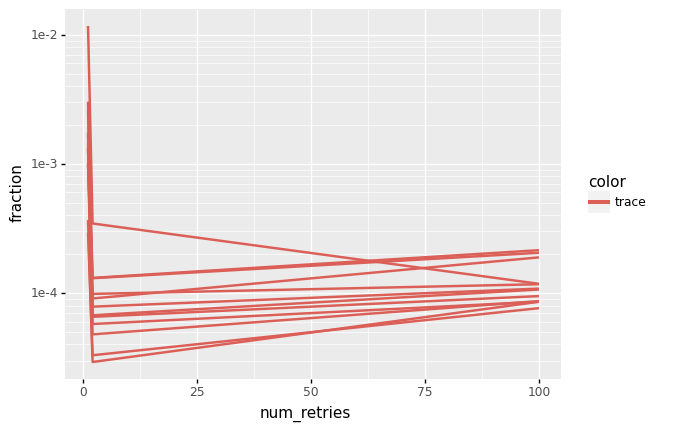

<ggplot: (8757981852757)>

In [116]:
plt = ggplot(vendor_results_df) +\
    geom_line(aes(x='retries', y='fraction', group='vendor', color='color'), size=1) +\
    scale_y_log10() +\
    xlab('num_retries')

plt.save('traces_vs_uniform-uniform_workload.png', dpi=300)
plt

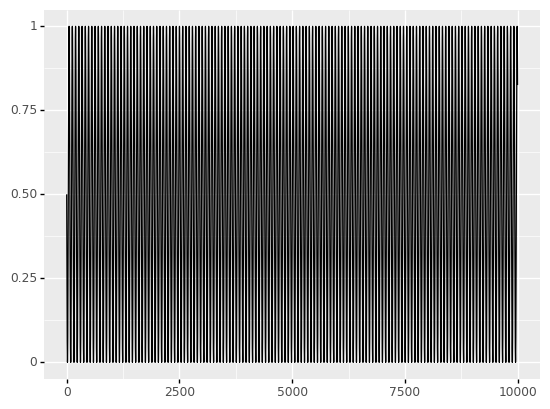

<ggplot: (8757963694102)>

In [140]:
x = np.linspace(-np.pi, np.pi, 24*3)
y = np.tile(np.sin(x) + 1, 365) / 2

ggplot()+\
    geom_line(aes(x=range(len(y))[:10000], y=y[:10000]))

In [128]:
2*np.pi / (12)

0.17453292519943295